<a href="https://colab.research.google.com/github/Nihar783/cifar100-resnet/blob/main/Image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32')/ 255.0


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum',
    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark',
    'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
    'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone',
    'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe',
    'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [ ]:
batch_size = 64
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_dataset = test_dataset.shuffle(len(x_test)).batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.shuffle(len(x_train)).batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
def plot_image(image, label, pred_label=None):
    fig, axs = plt.subplots(8, 8, figsize=(40, 40))
    x = 0
    for i in range (8):
        for j in range (8):
            axs[i, j].imshow(image[x])
            title = cifar100_fine_labels[label[x][0]]
            if pred_label is not None:
                title += " | Pred: " + cifar100_fine_labels[pred_label[x][0]]
            axs[i, j].set_title(title, fontsize=20)
            x += 1

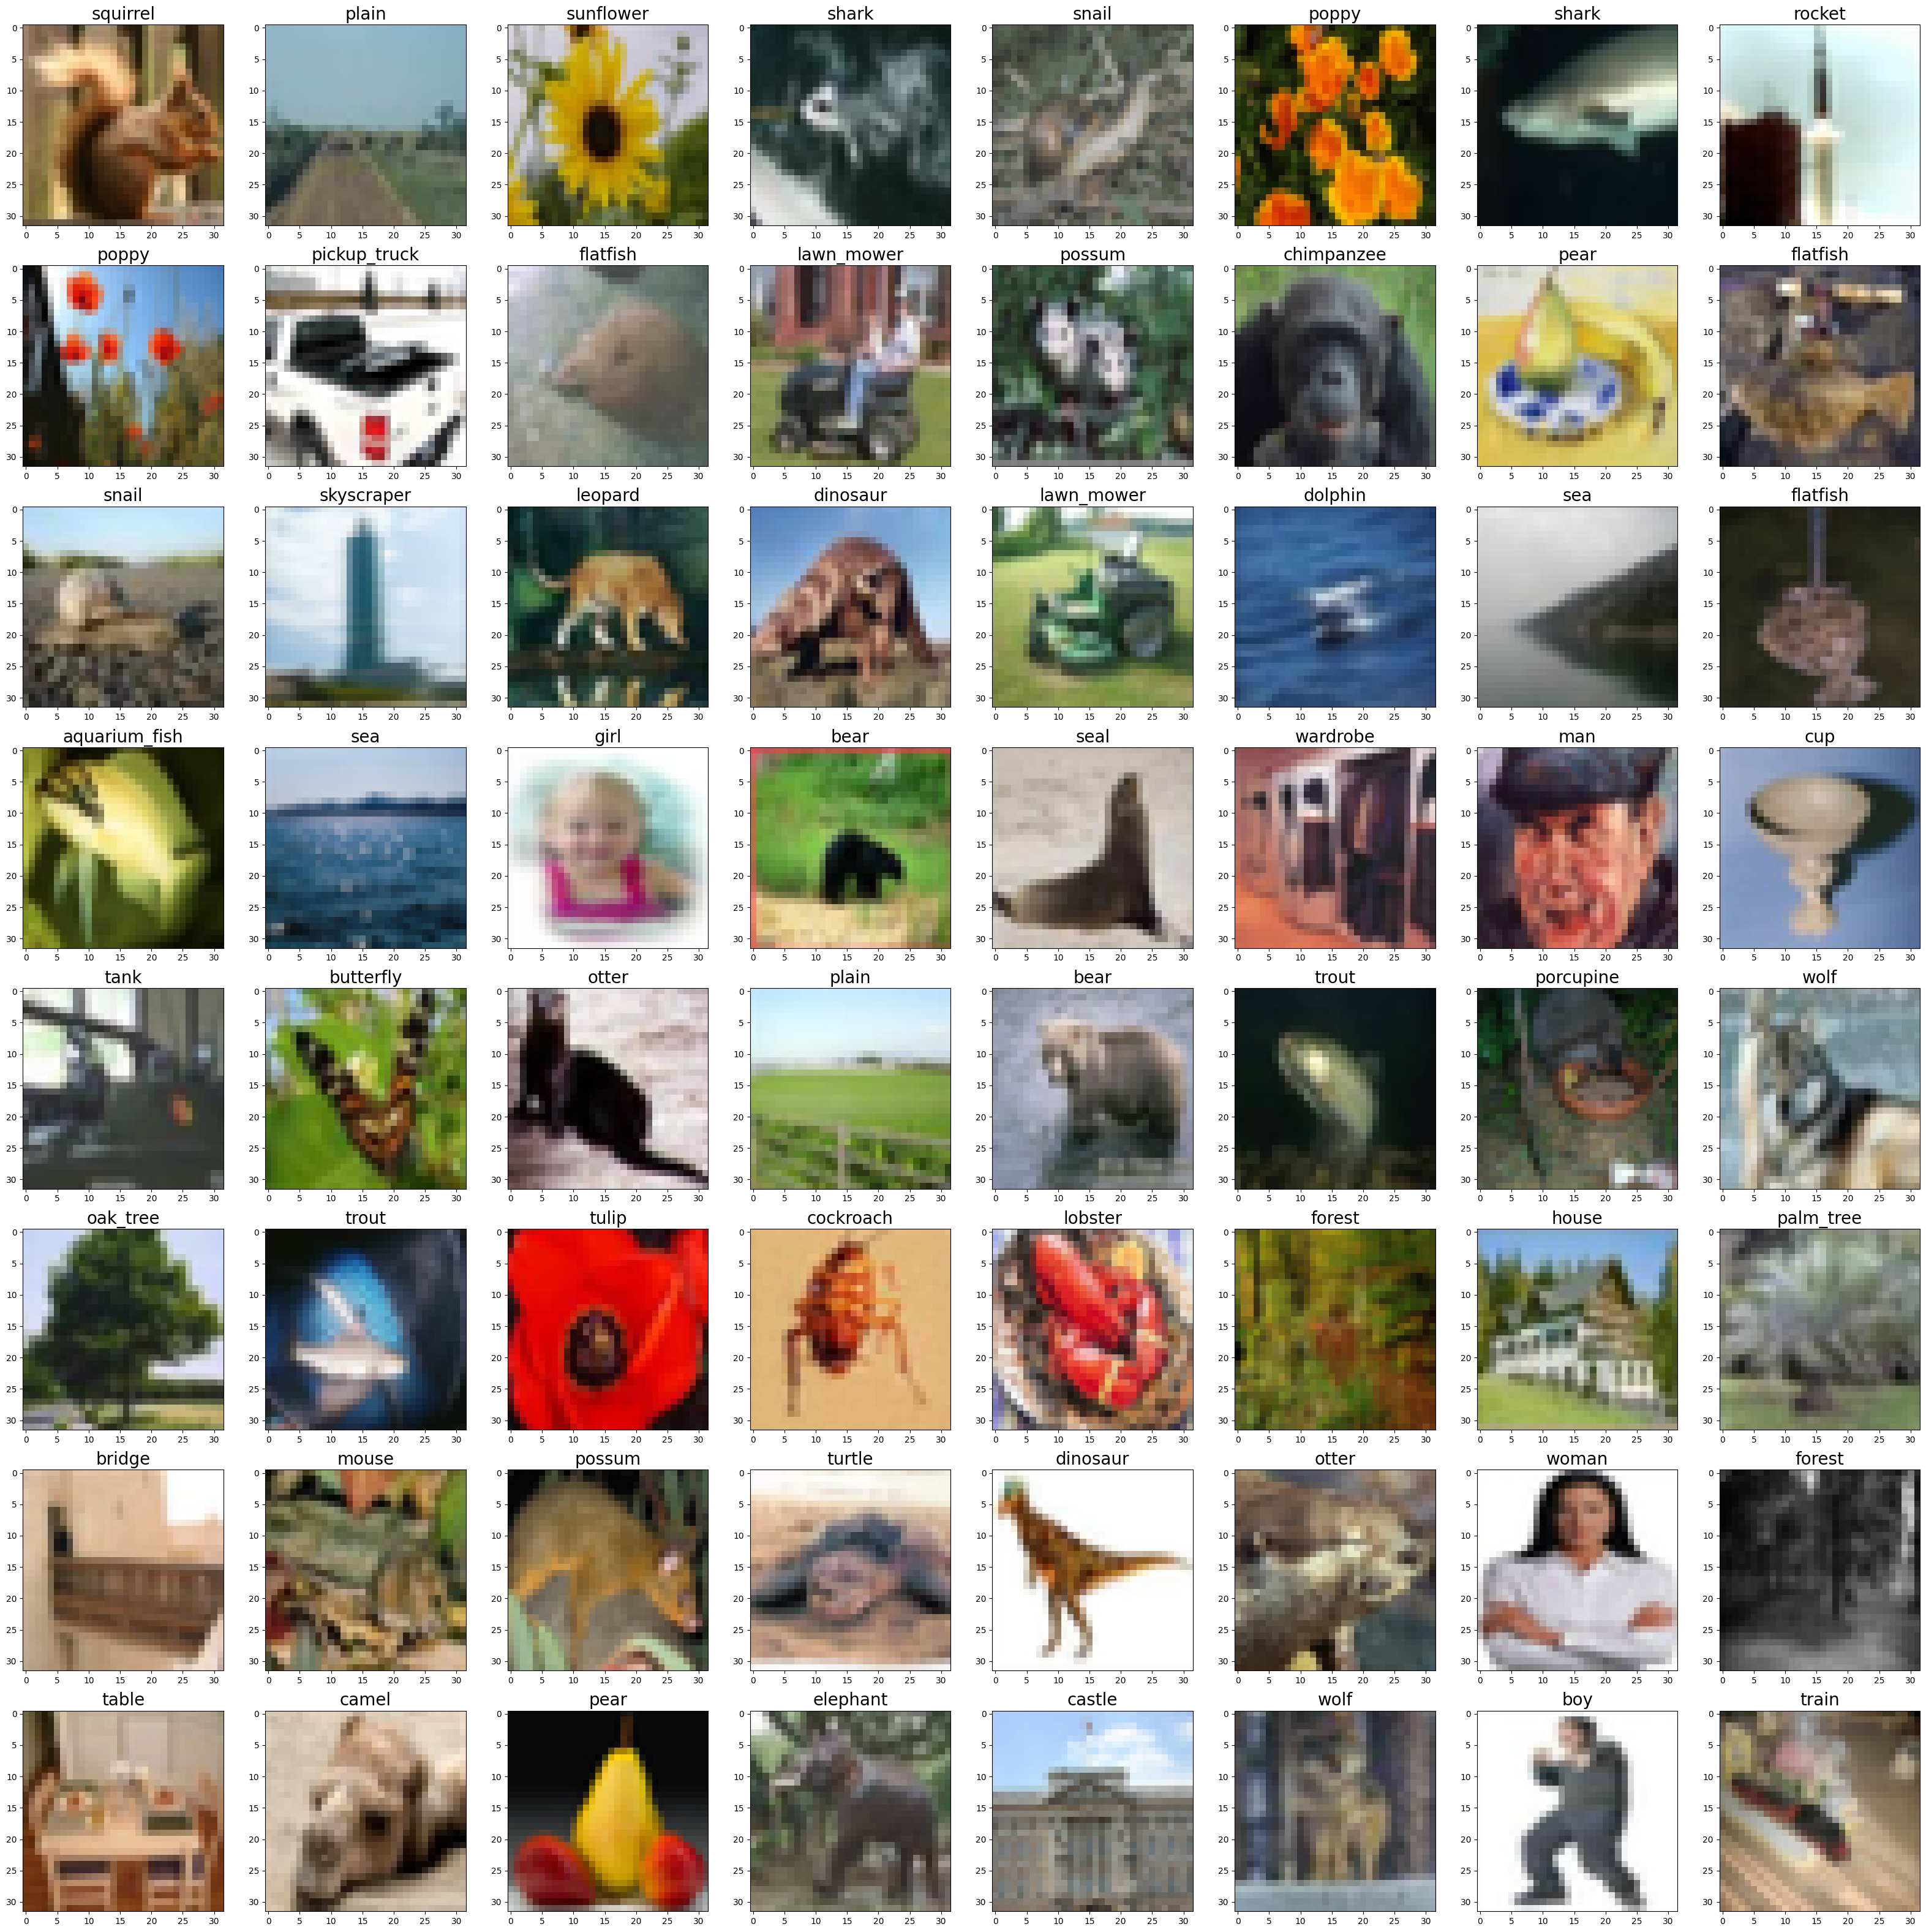

In [ ]:
iterator = iter(train_dataset)
image, label = next(iterator)
image = image.numpy()
label = label.numpy()
plot_image(image, label)


In [ ]:
img_height = 32
img_width = 32
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal',input_shape=(img_height,img_width,3)),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def residual_block(x, filters, downsample=False):
    stride = 2 if downsample else 1

    shortcut = x
    if downsample or x.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = tf.keras.layers.Add()([x, shortcut])
    x = Activation('relu')(x)

    return x


In [ ]:
def create_resnet():
    inputs = Input((32, 32, 3))
    x = data_augmentation(inputs)

    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stage 1
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # Stage 2
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)

    # Stage 3
    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)


    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(100, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

model = create_resnet()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4,
                                                 weight_decay=1e-4),
              metrics=['accuracy'])

In [ ]:

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                restore_best_weights=True)

In [ ]:
history = model.fit(train_dataset,
          batch_size=64,
          epochs=40,
          validation_data=test_dataset,
          validation_batch_size=64,
          callbacks=[early_stop]
                    )

Epoch 1/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - accuracy: 0.0540 - loss: 4.3966 - val_accuracy: 0.0901 - val_loss: 3.9894
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.1302 - loss: 3.7819 - val_accuracy: 0.1811 - val_loss: 3.4020
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.1756 - loss: 3.4950 - val_accuracy: 0.2539 - val_loss: 3.0880
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.2119 - loss: 3.2516 - val_accuracy: 0.2659 - val_loss: 2.9904
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.2458 - loss: 3.0792 - val_accuracy: 0.2951 - val_loss: 2.8580
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.2751 - loss: 2.9180 - val_accuracy: 0.3317 - val_loss: 2.6236
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.2986 - loss: 2.7758 - val_accuracy: 0.2992 - val_loss: 2.7565
Epoch 8/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.3246 - loss: 2.6535 - 

In [ ]:
model.summary()

NameError: name 'model' is not defined

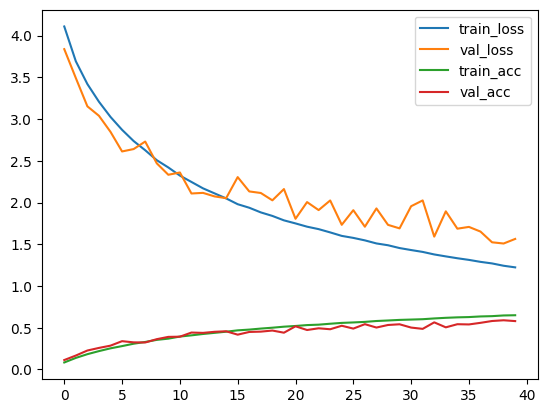

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step 


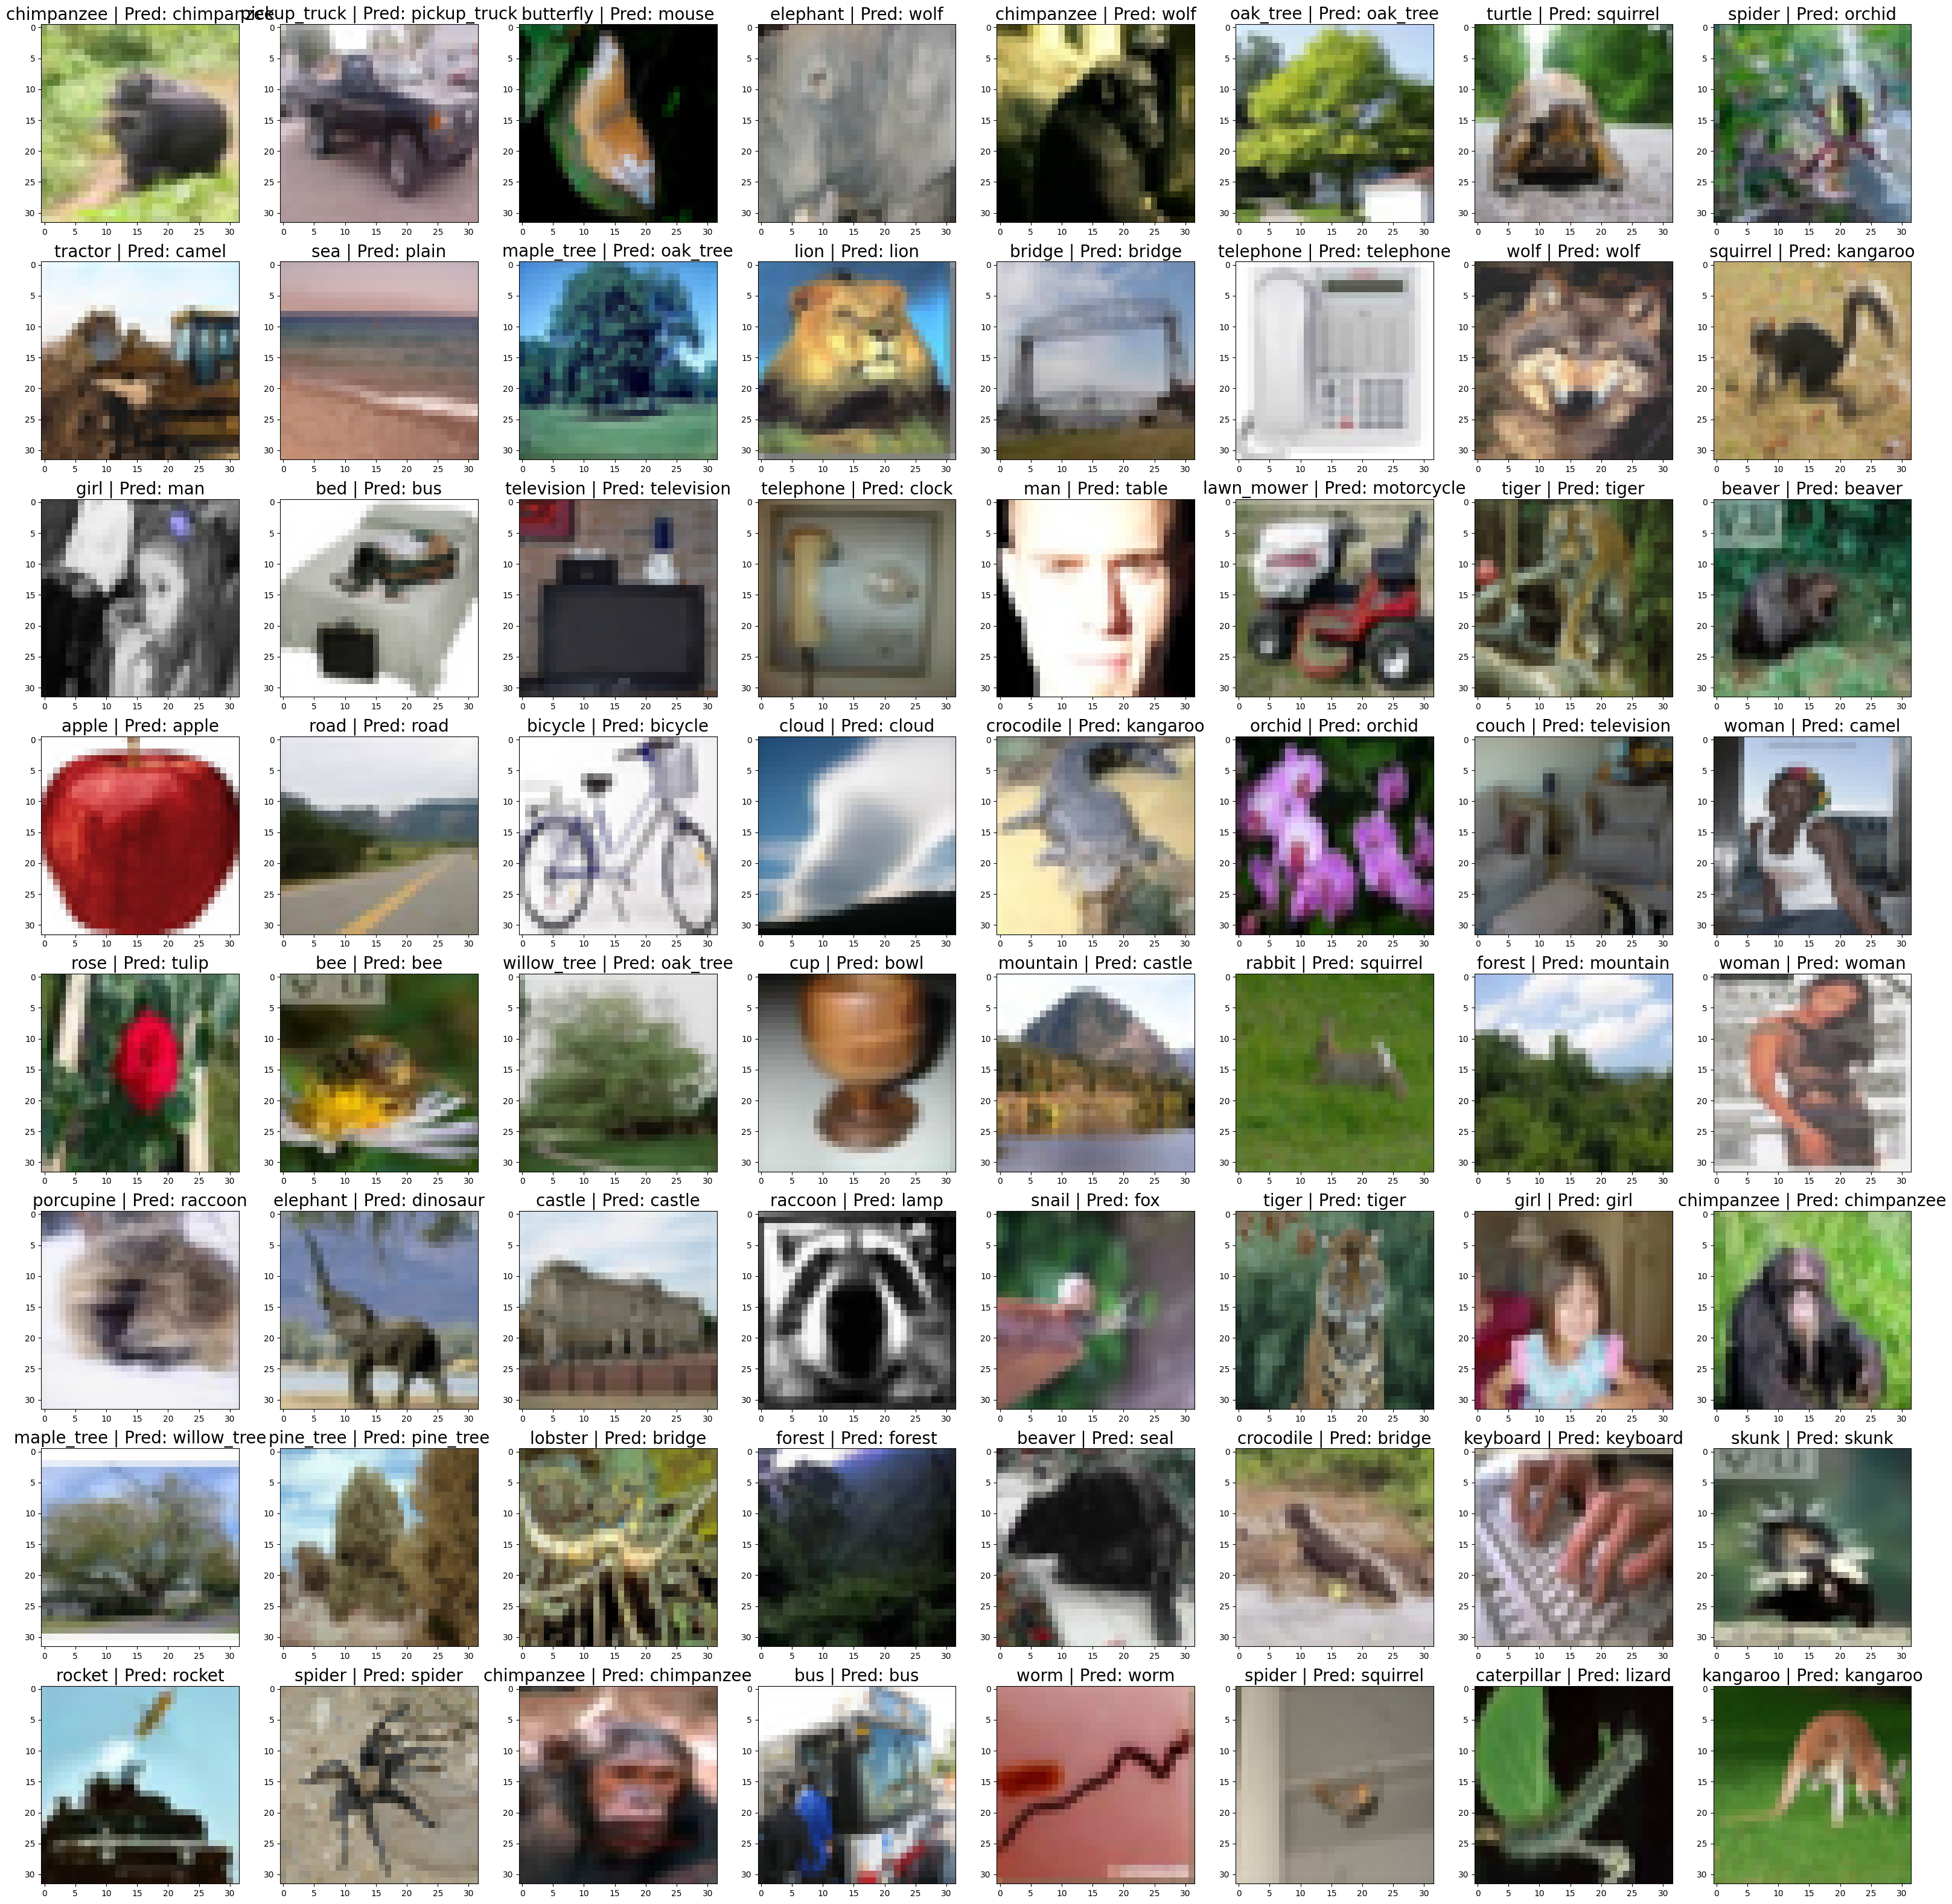

In [ ]:
test_iteration = iter(test_dataset)
test_imgs,test_labels = next(test_iteration)
pred_labels = model.predict(test_imgs)
pred_labels = np.argmax(pred_labels,axis=1)
pred_labels = pred_labels.reshape((64,1))
plot_image(test_imgs,label=test_labels,pred_label=pred_labels)

In [ ]:
los, acc = model.evaluate(test_dataset)
print("Test Loss:", los)
print("Test Accuracy:", acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5873 - loss: 1.5288
Test Loss: 1.5091861486434937
Test Accuracy: 0.5896000266075134
